In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, MultiHeadAttention, LayerNormalization

In [2]:
def calculate_psar(high, low, close, step=0.02, max_step=0.2):
    psar = close[0]
    af = step
    ep = high[0]
    trend = 1

    psar_list = [psar]
    
    for i in range(1, len(close)):
        psar = psar + af * (ep - psar)
        
        if trend == 1:
            psar = min(psar, low[i-1], low[i-2] if i > 1 else low[i-1])
            if psar > low[i]:
                trend = -1
                psar = ep
                ep = low[i]
                af = step
        else:
            psar = max(psar, high[i-1], high[i-2] if i > 1 else high[i-1])
            if psar < high[i]:
                trend = 1
                psar = ep
                ep = high[i]
                af = step

        if trend == 1:
            if high[i] > ep:
                ep = high[i]
                af = min(af + step, max_step)
        else:
            if low[i] < ep:
                ep = low[i]
                af = min(af + step, max_step)

        psar_list.append(psar)

    return np.array(psar_list)

In [3]:
symbol = "AAPL"
start_date = "2020-01-01"
end_date = "2023-12-31"
data = yf.download(symbol, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [4]:
data['SAR'] = calculate_psar(data['High'].values, data['Low'].values, data['Close'].values)

In [5]:
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'SAR']
target = 'Close'

In [6]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[features])

In [7]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length), :])
        y.append(data[i + seq_length, features.index(target)])
    return np.array(X), np.array(y)


In [8]:
seq_length = 30
X, y = create_sequences(scaled_data, seq_length)

In [9]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [10]:
def create_transformer_model(input_shape):
    inputs = Input(shape=input_shape)
    
    # Multi-Head Attention Layer
    attention_output = MultiHeadAttention(num_heads=4, key_dim=64)(inputs, inputs)
    attention_output = LayerNormalization(epsilon=1e-6)(attention_output + inputs)
    
    # LSTM Layers
    lstm_output = LSTM(64, return_sequences=True)(attention_output)
    lstm_output = LSTM(32)(lstm_output)
    
    # Output Layer
    outputs = Dense(1)(lstm_output)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

In [11]:
input_shape = (X_train.shape[1], X_train.shape[2])
model = create_transformer_model(input_shape)
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 102ms/step - loss: 0.0964 - val_loss: 0.0019
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.0073 - val_loss: 0.0031
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0047 - val_loss: 0.0051
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0040 - val_loss: 0.0052
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.0030 - val_loss: 0.0021
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.0035 - val_loss: 0.0015
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 0.0030 - val_loss: 0.0075
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0024 - val_loss: 0.0017
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.0023 - val_loss: 0.0018
Epoch 12/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0

In [12]:
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


In [13]:
train_predictions = scaler.inverse_transform(
    np.column_stack((
        train_predictions, 
        np.zeros((len(train_predictions), len(features)-1))
    ))
)[:, 0]

test_predictions = scaler.inverse_transform(
    np.column_stack((
        test_predictions, 
        np.zeros((len(test_predictions), len(features)-1))
    ))
)[:, 0]

In [14]:
train_dates = data.index[seq_length:split+seq_length]
test_dates = data.index[split+seq_length:]


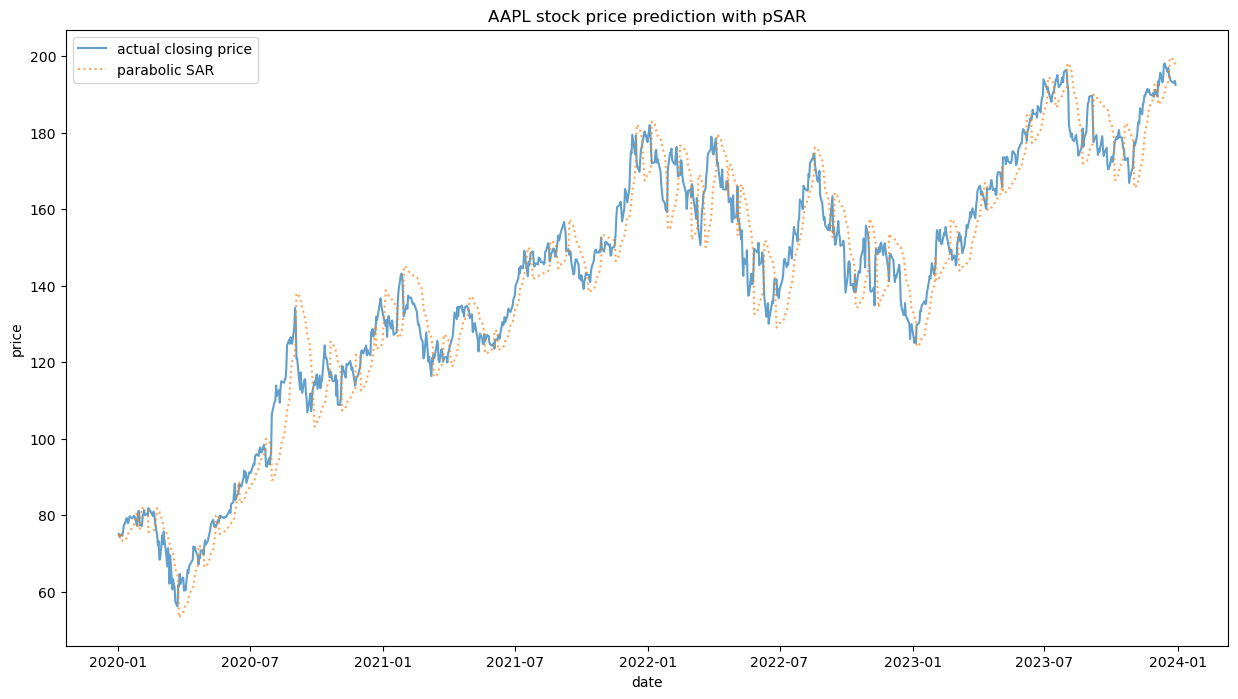

In [18]:
plt.figure(figsize=(15, 8))
plt.plot(data.index, data['Close'], label='actual closing price', alpha=0.7)
plt.plot(data.index, data['SAR'], label='parabolic SAR', alpha=0.7, linestyle='dotted')
plt.title(f'{symbol} stock price prediction with pSAR')
plt.xlabel('date')
plt.ylabel('price')
plt.legend()
plt.show()